In [1317]:
import pandas as pd
import numpy as np
import re
%matplotlib inline
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import  LabelEncoder

In [1358]:
file_name = 'Desktop/dataset/test.txt'
file = open(file_name,mode='r')
text = file.read()
file.close()

Попытаемся вытащить нужные строки регулярными выражениями

In [1319]:
search_time = r"\[[-:.\w\s]+\]"
result_time = re.findall(search_time,text)
len(result_time)

3609

In [1320]:
search_error = r"Error:[\s\w.:',/]+"
result_error = re.findall(search_error,text)
len(result_error)

3609

In [1321]:
search_params = r"Params: [.,:&%-=+\s\w]+"
result_params = re.findall(search_params,text)
len(result_params)

3607

В params есть строки без информации

In [1322]:
text_split = text.split('\n')
text_split = list(filter(None,text_split))


Если попробовать по индексам распределить на три группы time, params, error, то увидим, что порядок нарушается - надо искать выбросы

In [1323]:
a = []
k = 0
for i in range (len(text_split)):
    if (text_split[i][0] != '[') and (text_split[i][0] != 'P') and (text_split[i][0] != 'E') :
        a.append(i-k) 
        k +=1    
a

[696, 1767, 4035, 6369, 6792, 6792, 6906, 9618, 9669, 10440, 10584, 10779]

In [1324]:
text_split[a[0]]

'amount=250000,  mm=0'

In [1326]:
for i in a:
    del text_split[i]

In [1327]:
len(text_split)

10827

In [1328]:
time = []
id = []
error = []
for i in range (0,len(text_split),3):
    time.append(text_split[i])
for i in range (1,len(text_split),3):
    id.append(text_split[i])
for i in range (2,len(text_split),3):
    error.append(text_split[i])
    

In [1329]:
len(id)

3609

In [1330]:
data = pd.DataFrame()
data['time'] = pd.Series(time)
data['id'] = pd.Series(id)
data['error'] = pd.Series(error)

In [1331]:
data.head()

,time,id,error
0,[2019-09-25 04:00:25.451360],Params: account_id=0d7f144d5f63b8b6d12aa8730eb...,"Error: Error, online session is not available...."
1,[2019-09-25 04:00:46.710930],Params: account_id=0d7f144d5f63b8b6d12aa8730eb...,"Error: Error, online session is not available...."
2,[2019-09-25 04:01:34.980043],Params: account_id=82eb330fd6ea654a92aefd63284...,"Error: Error, online session is not available...."
3,[2019-09-25 04:02:25.045196],Params: account_id=981593d026c670a0d4af35b8111...,"Error: Error, online session is not available...."
4,[2019-09-25 04:02:37.805390],Params: account_id=0d7f144d5f63b8b6d12aa8730eb...,"Error: Error, online session is not available...."


Ищем короткую строку в колонке id

In [1333]:
def clean (data):
    k = []
    for i in range(data.shape[0]):
        if len(data['id'][i]) < 100:
            k.append(i)
    print(k)
    l = 0
    for i in k:
        data = data.drop(i-l, axis= 0)
        data = data.set_index(np.arange(data.shape[0]))
        l +=1
    return data

In [1334]:
data = clean(data)

[1214, 1218]


Есть строки с одинаковыми значениями params

In [1254]:
data['id'].value_counts().head()

Params: account_id=6aa2d1c23beef78ac3c3aaab479e3dee&client_id=0454399a7d212837739620774ea76a4a&channel=SITE&is_js=1&useragent=Mozilla%2F5.0+%28iPhone%3B+CPU+iPhone+OS+11_2_5+like+Mac+OS+X%29+AppleWebKit%2F604.5.6+%28KHTML%2C+like+Gecko%29+Version%2F11.0+Mobile%2F15D60+Safari%2F604.1&time_zone=3&time_local=22.08.2019+17%3A08%3A56&time_utc3=22.08.2019+17%3A08%3A56&ph_country=7&phone=cea21583bf7679869f20ec3b45595747&mail=76f2635e6b29dbbe448fe9889f6e5ca3&referrer=&tenor=14&amount=5000&cookie=ec8b9814e5b1188b178dd14f437de8ea&zip_billing=422120&zip_shipping=422120&country_code_billing=RU&country_code_shipping=RU&response_content_type=json&version=10                                                         4
Params: version=11&account_id=aae1077ae5692de5c67700542d89f714&client_id=0a25516824599fbce915b84ce8887551&application_id=00000026&channel=SITE&is_js=1&useragent=Mozilla/5.0%20(Windows%20NT%2010.0;%20Win64;%20x64)%20AppleWebKit/537.36%20(KHTML,%20like%20Gecko)%20Chrome/77.0.3865.75%20Safari

In [1335]:
data['name_time'] = data['time'].apply(lambda s: s[1:20])

Считаем, что строки дублируются, если у них три поля одинаковые

In [1336]:
data = data.drop_duplicates(['id','error','name_time'], keep = 'first')
data = data.set_index(np.arange(data.shape[0]))

Сгенирируем несколько признаков

In [1337]:
id_name_a = r"account_id=\w+"
def id_name (series):
    result_time = re.findall(id_name_a,series)
    return result_time[0][11:]

In [1338]:
channel_a = r"channel=[\w]+"
def channel_name (series):
    result_time = re.findall(chanel_a,series)
    return result_time[0][8:]

In [1339]:
data['channel'] = data['id'].apply(channel_name)

In [1340]:
data['account_id'] = data['id'].apply(id_name)

In [1341]:
data['name_time'] = data['name_time'].apply(pd.to_datetime)

In [1342]:
data['hour'] = data['name_time'].apply(lambda s: s.hour)

Посмотрим на временное распределение

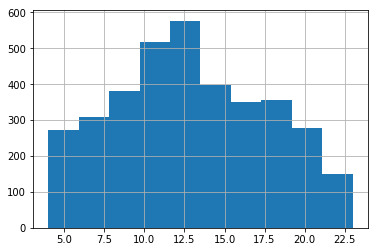

In [1343]:
data['hour'].hist();

В обед - максимум, ночью тишина.

Распределение количества ошибок в зависимости от клиента

In [1270]:
data['account_id'].value_counts()

6aa2d1c23beef78ac3c3aaab479e3dee    787
0d7f144d5f63b8b6d12aa8730ebdcd38    778
22d039994e86d6468bb8dbd4467c0b98    669
981593d026c670a0d4af35b811119137    496
24b659f5c4e3a41ac131ec9f31ef7eac    198
5e7732d5cc60c8b2b3bcb513a093baae    141
82eb330fd6ea654a92aefd63284d8ece     74
3dc8e019c0fca5d34d127083dd0dadec     71
2b2e1ae5a00d8888296e07d9a935d74b     65
aae1077ae5692de5c67700542d89f714     63
b9f790c3d1ac237361d17f9c0d345add     60
f56878cef2b4e8c0a6f07ceb9d74071f     54
25aef575c3c8796202d51c26668ef5fd     27
5eadde2b43fd0d3f2e7e6f3936572d5e     15
d460b70aeaf5eba0f41c399934cc0904     14
d84a9db82d5d005d43d337edc2b74c12     13
4dd5008f729abc3e1d57a4334a013892      8
ab5885f8d3877ee4cf561fc179ec312b      8
ba48f38ce5d7c7f1130fdab6c6c88a78      7
b89a0c92f0603961b5e1a09711dbd862      6
8b4ca7fbc6a918c8df8382fb27d4ea2e      6
b36bf7f59194c964f578861d29112639      6
63058c733ece4ddf2171116ac39b3850      6
67cc4694f7d2cb60df3abcbf83e60a6e      4
123641d47167dcc5792126d813b5530f      4


Название id очень длинные, закодируем их чтобы было удобнее

In [1344]:
one = LabelEncoder()
one.fit(np.array(data['account_id']).reshape(-1,1))
data['one'] = one.transform(np.array(data['account_id']).reshape(-1,1))

In [1345]:
d = dict(zip(data['one'].value_counts().index,data['account_id'].value_counts().index))

In [1346]:
d

{16: '6aa2d1c23beef78ac3c3aaab479e3dee',
 0: '0d7f144d5f63b8b6d12aa8730ebdcd38',
 4: '22d039994e86d6468bb8dbd4467c0b98',
 20: '981593d026c670a0d4af35b811119137',
 6: '24b659f5c4e3a41ac131ec9f31ef7eac',
 12: '5e7732d5cc60c8b2b3bcb513a093baae',
 17: '82eb330fd6ea654a92aefd63284d8ece',
 9: '3dc8e019c0fca5d34d127083dd0dadec',
 8: '2b2e1ae5a00d8888296e07d9a935d74b',
 21: 'aae1077ae5692de5c67700542d89f714',
 25: 'b9f790c3d1ac237361d17f9c0d345add',
 29: 'f56878cef2b4e8c0a6f07ceb9d74071f',
 7: '25aef575c3c8796202d51c26668ef5fd',
 13: '5eadde2b43fd0d3f2e7e6f3936572d5e',
 27: 'd460b70aeaf5eba0f41c399934cc0904',
 28: 'd84a9db82d5d005d43d337edc2b74c12',
 22: '4dd5008f729abc3e1d57a4334a013892',
 11: 'ab5885f8d3877ee4cf561fc179ec312b',
 26: 'ba48f38ce5d7c7f1130fdab6c6c88a78',
 24: 'b89a0c92f0603961b5e1a09711dbd862',
 18: '8b4ca7fbc6a918c8df8382fb27d4ea2e',
 14: 'b36bf7f59194c964f578861d29112639',
 23: '63058c733ece4ddf2171116ac39b3850',
 1: '67cc4694f7d2cb60df3abcbf83e60a6e',
 15: '123641d47167dcc57

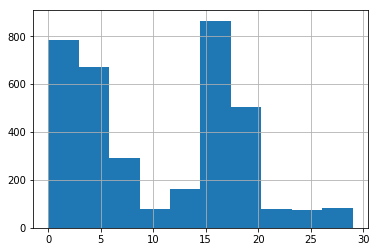

In [1277]:
data['one'].hist();

4 гиперактивных id

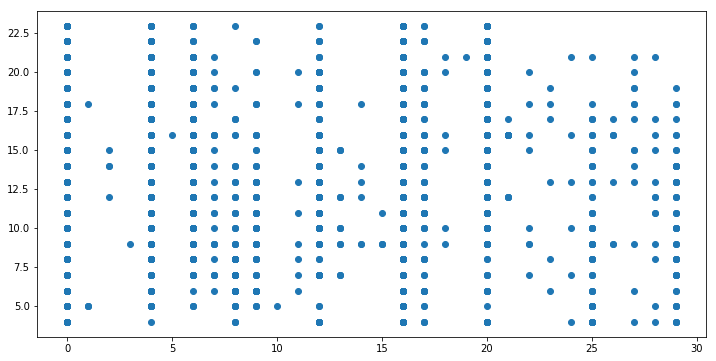

In [1347]:
fig = plt.figure(figsize = (12,6))
plt.scatter(data['one'], data['hour']);

In [1348]:
data['one'].value_counts().head(4)

16    787
0     778
4     669
20    496
Name: one, dtype: int64

Гиперактивные id встречаются на протяжении всего дня (с 6 до 00).

Посмотрим на ошибки

In [1349]:
data['error'].value_counts()

Error: Error, online session is not available. Please, verify js/mobile library installation    3289
Error: Authentication failed                                                                     293
Error: Parameter time_utc3 is more then local server time > 65 min                                 4
Error: Mandatory parameter time_utc3 is empty                                                      1
Error: 5:'ascii' codec can't decode byte 0xd0 in position 0: ordinal not in range(128)             1
Name: error, dtype: int64

In [1350]:
pd.crosstab(data['account_id'], data['error'])

error,Error: 5:'ascii' codec can't decode byte 0xd0 in position 0: ordinal not in range(128),Error: Authentication failed,"Error: Error, online session is not available. Please, verify js/mobile library installation",Error: Mandatory parameter time_utc3 is empty,Error: Parameter time_utc3 is more then local server time > 65 min
account_id,,,,,
0d7f144d5f63b8b6d12aa8730ebdcd38,0,0,778,0,0
10b36dfb820e966bc8c44efc05804f81,0,0,4,0,0
123641d47167dcc5792126d813b5530f,0,4,0,0,0
13dd6713dcec5a44fb5fe5125dd3d9a0,0,0,0,0,1
22d039994e86d6468bb8dbd4467c0b98,0,289,380,0,0
2443f606ab9461d23e39c4310c552daf,0,0,0,0,1
24b659f5c4e3a41ac131ec9f31ef7eac,1,0,197,0,0
25aef575c3c8796202d51c26668ef5fd,0,0,27,0,0
2b2e1ae5a00d8888296e07d9a935d74b,0,0,65,0,0


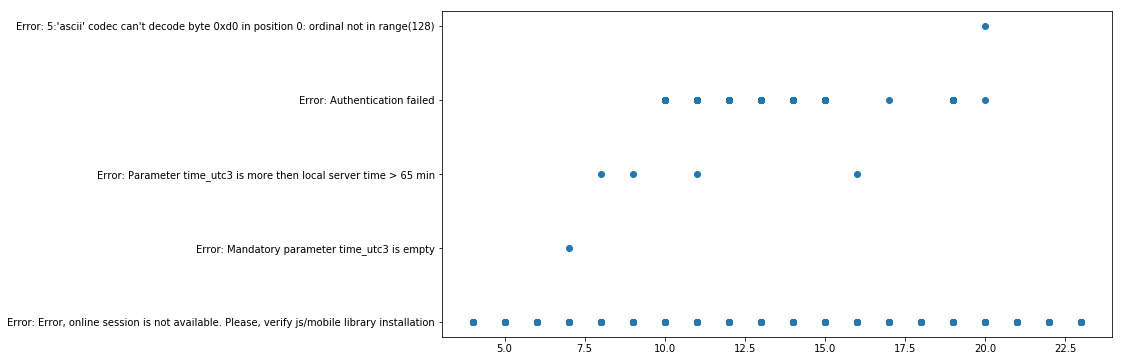

In [1351]:
fig = plt.figure(figsize = (12,6))
plt.scatter(data['hour'], data['error']);

id 22d039994e86d6468bb8dbd4467c0b98	289 раз получал ошибку аутентификации на протяжении 9 часов

In [1352]:
data['channel'].value_counts()

SITE         3528
PHONE_APP      60
Name: channel, dtype: int64

In [1354]:
pd.crosstab(data['error'], data['channel'])

channel,PHONE_APP,SITE
error,,
Error: 5:'ascii' codec can't decode byte 0xd0 in position 0: ordinal not in range(128),0,1
Error: Authentication failed,0,293
"Error: Error, online session is not available. Please, verify js/mobile library installation",60,3229
Error: Mandatory parameter time_utc3 is empty,0,1
Error: Parameter time_utc3 is more then local server time > 65 min,0,4


Ошибку аутентификации получали при использовании сайта

In [1355]:
pd.crosstab(data['account_id'], data['channel'])

channel,PHONE_APP,SITE
account_id,,
0d7f144d5f63b8b6d12aa8730ebdcd38,0,778
10b36dfb820e966bc8c44efc05804f81,0,4
123641d47167dcc5792126d813b5530f,0,4
13dd6713dcec5a44fb5fe5125dd3d9a0,0,1
22d039994e86d6468bb8dbd4467c0b98,0,669
2443f606ab9461d23e39c4310c552daf,0,1
24b659f5c4e3a41ac131ec9f31ef7eac,0,198
25aef575c3c8796202d51c26668ef5fd,5,22
2b2e1ae5a00d8888296e07d9a935d74b,0,65


Один из гиперактивных id пользуется мобильным приложением

Возвращаясь к дубликатам. Имеется 420 одинаковых строк Params, однако время сессий разное. Что это может быть? Нужно ли это учитывать или же это выбросы? Наверное, зависит от конкретной задачи, однако если их убрать, то распределение по account_id будет выглядеть следующим образом

In [1356]:
data = data.drop_duplicates('id', keep = 'first')

In [1357]:
data['account_id'].value_counts()

0d7f144d5f63b8b6d12aa8730ebdcd38    778
22d039994e86d6468bb8dbd4467c0b98    667
981593d026c670a0d4af35b811119137    496
6aa2d1c23beef78ac3c3aaab479e3dee    428
24b659f5c4e3a41ac131ec9f31ef7eac    198
82eb330fd6ea654a92aefd63284d8ece     74
5e7732d5cc60c8b2b3bcb513a093baae     73
3dc8e019c0fca5d34d127083dd0dadec     71
2b2e1ae5a00d8888296e07d9a935d74b     65
b9f790c3d1ac237361d17f9c0d345add     60
aae1077ae5692de5c67700542d89f714     57
f56878cef2b4e8c0a6f07ceb9d74071f     54
25aef575c3c8796202d51c26668ef5fd     27
5eadde2b43fd0d3f2e7e6f3936572d5e     15
d460b70aeaf5eba0f41c399934cc0904     14
d84a9db82d5d005d43d337edc2b74c12     13
4dd5008f729abc3e1d57a4334a013892      8
ab5885f8d3877ee4cf561fc179ec312b      8
ba48f38ce5d7c7f1130fdab6c6c88a78      7
b89a0c92f0603961b5e1a09711dbd862      6
8b4ca7fbc6a918c8df8382fb27d4ea2e      6
b36bf7f59194c964f578861d29112639      6
63058c733ece4ddf2171116ac39b3850      6
67cc4694f7d2cb60df3abcbf83e60a6e      4
123641d47167dcc5792126d813b5530f      4


Получается, что почти все эти дубликаты принадлежат 6aa2d1c23beef78ac3c3aaab479e3dee